# References

# Modified from KEFE's preprocess_review.py

In [1]:
!python --version
!pwd

Python 3.7.6
/Users/enlik/GitRepo/master-thesis-2021/notebooks


In [35]:
from utils import *
from pprint import pprint

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

config = get_config('config.yaml')

# Let's Get Started

## Test

In [3]:
df = read_csv_from_gdrive(config['csv_input']['uber_google'])
total_reviews = len(df)
unique_users  = len(df['userName'].unique())
unknown_users = len(df[df['userName']=='A Google user'])
mean = df['score'].mean()

print(f'Total English reviews: {total_reviews} \n')
print(f'Total unique users : {unique_users}')
print(f'Total unknown users: {unknown_users}')
print(f'Total users who gave multiple reviews: {total_reviews - unique_users - unknown_users}\n')
print(f'Average rating for this app based on the textual reviews: {round(mean,2)} \n')

Total English reviews: 10000 

Total unique users : 9911
Total unknown users: 26
Total users who gave multiple reviews: 63

Average rating for this app based on the textual reviews: 3.3 



In [4]:
cleaned_docs = remove_things(df['content'])

In [5]:
lists_of_words = list(sentences_to_words(cleaned_docs))
lists_of_words_no_stops = remove_stopwords(lists_of_words)

In [6]:
ngrams = make_bigrams(lists_of_words_no_stops)

Making bigrams...


In [7]:
data_lemmatized = lemmatize(ngrams, allowed_postags=['NOUN'])
data_lemmatized

Lemmatizing...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[['fare', 'mob', 'good_job', 'guy'],
 [],
 ['courteous_driver'],
 ['form', 'payment', 'day', 'update'],
 ['care_customer', 'location', 'money', 'credit', 'ride', 'mucb', 'time'],
 ['ride'],
 ['address', 'error', 'evoke', 'way', 'problem', 'problem'],
 ['thank'],
 ['mark',
  'name',
  'facility',
  'making_money',
  'cancelling_trips',
  'driver',
  'penalty',
  'money',
  'customer',
  'user',
  'trip',
  'people',
  'name',
  'reality',
  'cant_even',
  'grade',
  'service',
  'rating',
  'rate'],
 ['problem', 'way', 'comment', 'problem', 'problem', 'rating', 'offer', 'way'],
 ['ride', 'request', 'minute', 'car', 'rate', 'bit', 'lyft', 'second'],
 ['facility'],
 ['service',
  'taxi',
  'dollar',
  'taxi',
  'price',
  'price',
  'pay',
  'dollar',
  'difference'],
 ['book', 'trip', 'function'],
 ['cost', 'ride', 'solve', 'bug'],
 ['get'],
 ['thank', 'helping', 'service'],
 ['app', 'location'],
 ['complaint'],
 ['customer', 'centric', 'care_customer'],
 ['total', 'paytm', 'travelling']

In [14]:
corpora.Dictionary(data_lemmatized)

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [15]:
id2word[0]

'fare'

In [16]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('fare', 1), ('good_job', 1), ('guy', 1), ('mob', 1)]]

# Topic Modelling

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [24]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.255*"problem" + 0.239*"phone" + 0.110*"contact" + 0.102*"lot" + '
  '0.072*"rating" + 0.049*"offer" + 0.021*"kind" + 0.005*"pathetic_service" + '
  '0.000*"use" + 0.000*"website"'),
 (1,
  '0.267*"auto" + 0.102*"search" + 0.069*"install" + 0.032*"gps" + '
  '0.020*"credit" + 0.000*"hour" + 0.000*"none" + 0.000*"functionality" + '
  '0.000*"food" + 0.000*"year"'),
 (2,
  '0.188*"help" + 0.174*"support" + 0.122*"today" + 0.092*"month" + '
  '0.079*"booking" + 0.061*"user" + 0.057*"worst_app" + 0.035*"min" + '
  '0.013*"name" + 0.011*"trash"'),
 (3,
  '0.718*"app" + 0.084*"thank" + 0.059*"cost" + 0.027*"bug" + 0.014*"alot" + '
  '0.005*"solve" + 0.003*"comment" + 0.000*"use" + 0.000*"rider" + '
  '0.000*"reason"'),
 (4,
  '0.240*"customer" + 0.179*"card" + 0.168*"experience" + 0.109*"route" + '
  '0.083*"order" + 0.026*"choice" + 0.023*"pickup_location" + '
  '0.022*"cancelation" + 0.012*"respond" + 0.005*"partner"'),
 (5,
  '0.234*"cancel" + 0.212*"place" + 0.195*"company" + 0.

In [25]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.876202965402765

Coherence Score:  0.4027589242413221


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.317494  0.310484       1        1  16.080288
19    -0.217245 -0.328770       2        1  10.420518
6     -0.097799 -0.034714       3        1   7.612855
3     -0.119016 -0.050179       4        1   7.348250
7     -0.057905 -0.014512       5        1   6.986951
11    -0.098527 -0.035266       6        1   6.916139
4     -0.000276  0.002048       7        1   5.221733
16     0.012879  0.004942       8        1   4.380942
2      0.030402  0.008009       9        1   4.294120
18     0.015245  0.004936      10        1   4.254549
10     0.019249  0.005726      11        1   4.233028
0      0.018758  0.005758      12        1   3.875990
12     0.075607  0.013749      13        1   3.184392
17     0.067608  0.012958      14        1   3.152271
14     0.060207  0.011958      15        1   2.965969
15     0.093210  0.015690      16        1   2.922067
13     0.099257  0.016122      17        1   2.606331
5      0.092308  0.015573      18        1   2.600480
1      0.155815  0.018193      19        1   0.798268
8      0.167718  0.017295      20        1   0.144858, topic_info=            Term         Freq        Total Category  logprob  loglift
25        driver  4320.000000  4320.000000  Default   30.000  30.0000
14          ride  2054.000000  2054.000000  Default   29.000  29.0000
59           app  1745.000000  1745.000000  Default   28.000  28.0000
15          time  1839.000000  1839.000000  Default   27.000  27.0000
36       service  1373.000000  1373.000000  Default   26.000  26.0000
..           ...          ...          ...      ...      ...      ...
25        driver     0.013873  4320.551098  Topic20   -8.147  -6.1118
26      facility     0.013873     7.451261  Topic20   -8.147   0.2510
27         grade     0.013873     1.177487  Topic20   -8.147   2.0960
28  making_money     0.013873     1.177475  Topic20   -8.147   2.0960
29          mark     0.013873     1.177524  Topic20   -8.147   2.0959

[841 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
182      10  0.997008    account
16        8  0.993825    address
112       4  0.976327       alot
178       6  0.996479     amount
59        4  0.999474        app
...     ...       ...        ...
133      18  0.933497    weather
93       10  0.986795       week
94       10  0.995220       work
139       9  0.985270  worst_app
162       3  0.986372  yesterday

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 20, 7, 4, 8, 12, 5, 17, 3, 19, 11, 1, 13, 18, 15, 16, 14, 6, 2, 9])

In [30]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'libs/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [31]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(2,
  [('amount', 0.12326169405815424),
   ('cab', 0.06826801517067003),
   ('time', 0.0632111251580278),
   ('booking', 0.05815423514538559),
   ('change', 0.056890012642225034),
   ('information', 0.03982300884955752),
   ('rating', 0.038558786346396964),
   ('year', 0.03413400758533502),
   ('transportation', 0.02718078381795196),
   ('life', 0.025284450063211124)]),
 (15,
  [('time', 0.21093247588424438),
   ('experience', 0.13311897106109324),
   ('love', 0.09453376205787781),
   ('lot', 0.0707395498392283),
   ('fee', 0.06881028938906752),
   ('travel', 0.05016077170418006),
   ('book', 0.03215434083601286),
   ('promotion', 0.01864951768488746),
   ('hour', 0.01607717041800643),
   ('kind', 0.014790996784565916)]),
 (0,
  [('work', 0.13947696139476962),
   ('day', 0.10647571606475716),
   ('guy', 0.09402241594022416),
   ('route', 0.05292652552926526),
   ('ride', 0.04420921544209216),
   ('week', 0.03798256537982565),
   ('home', 0.0323785803237858),
   ('night', 0.03113325031

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [33]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

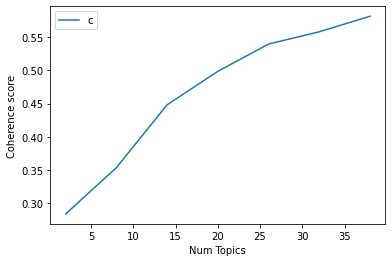

In [36]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.2834
Num Topics = 8  has Coherence Value of 0.3533
Num Topics = 14  has Coherence Value of 0.4482
Num Topics = 20  has Coherence Value of 0.4987
Num Topics = 26  has Coherence Value of 0.5399
Num Topics = 32  has Coherence Value of 0.5584
Num Topics = 38  has Coherence Value of 0.5818


In [38]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.158*"account" + 0.075*"email" + 0.059*"response" + 0.053*"update" + '
  '0.051*"message" + 0.043*"error" + 0.040*"request" + 0.037*"information" + '
  '0.034*"sign" + 0.024*"notification"'),
 (1,
  '0.501*"driver" + 0.060*"cancel" + 0.051*"route" + 0.021*"behavior" + '
  '0.019*"world" + 0.018*"transport" + 0.015*"option" + 0.011*"convenience" + '
  '0.010*"great_experience" + 0.009*"travelling"'),
 (2,
  '0.364*"ride" + 0.074*"application" + 0.071*"call" + 0.059*"booking" + '
  '0.034*"end" + 0.028*"book" + 0.024*"rupee" + 0.020*"min" + 0.020*"discount" '
  '+ 0.018*"check"'),
 (3,
  '0.599*"driver" + 0.096*"minute" + 0.025*"ola" + 0.017*"report" + '
  '0.016*"direction" + 0.015*"lot" + 0.010*"behaviour" + 0.007*"station" + '
  '0.006*"language" + 0.006*"moment"'),
 (4,
  '0.152*"location" + 0.112*"day" + 0.107*"phone" + 0.070*"today" + '
  '0.060*"every_time" + 0.023*"morning" + 0.020*"traffic" + 0.019*"road" + '
  '0.019*"week" + 0.014*"gps"'),
 (5,
  '0.351*"service" + 0.

In [47]:
data = df.content.values.tolist()

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.0833,"driver, amount, cash, money, guy, worst_app, c...",Amazing just absolutely love the cheap fares a...
1,1,0.0,0.0500,"account, email, response, update, message, err...",Superb services with Uber cab..I loving it.Tha...
2,2,15.0,0.0599,"issue, option, payment, contact, rating, syste...",Always on time. Courteous drivers... Highly re...
3,3,15.0,0.0751,"issue, option, payment, contact, rating, syste...",I had to use Lyft the last 2 days because Uber...
4,4,8.0,0.0692,"ride, card, thing, fee, everytime, year, start...",Terrible.. Drivers are rude and Uber don't eve...
5,5,8.0,0.0599,"ride, card, thing, fee, everytime, year, start...",Excellent ride. Clean and safe
6,6,19.0,0.0758,"trip, problem, vehicle, service, area, toll, r...",No way to re address a passenger or fair error...
7,7,0.0,0.0500,"account, email, response, update, message, err...",Very fantastic. I love uber and i trust uber. ...
8,8,5.0,0.0804,"service, people, cab, emergency, experience, g...",Uber is such a black mark on the name of provi...
9,9,19.0,0.0923,"trip, problem, vehicle, service, area, toll, r...",Usually quite good. However when there is the ...


In [48]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1894,"account, email, response, update, message, err...",I signed up for Uber and immediately started g...
1,1.0,0.1328,"driver, cancel, route, behavior, world, transp...","Dear Uber, we are just looking for good altern..."
2,2.0,0.1393,"ride, application, call, booking, end, book, r...","Well i like Uber ride,but after some experienc..."
3,3.0,0.1495,"driver, minute, ola, report, direction, lot, b...","Estimation was 2 minutes, I hurried to meet th..."
4,4.0,0.1581,"location, day, phone, today, every_time, morni...",The drivers are very unprofessional.... They c...


In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,14.0,"driver, amount, cash, money, guy, worst_app, c...",2161.0,0.2161
1.0,0.0,"account, email, response, update, message, err...",440.0,0.0440
2.0,15.0,"issue, option, payment, contact, rating, syste...",475.0,0.0475
3.0,15.0,"issue, option, payment, contact, rating, syste...",467.0,0.0467
4.0,8.0,"ride, card, thing, fee, everytime, year, start...",447.0,0.0447
...,...,...,...,...
9995.0,5.0,"service, people, cab, emergency, experience, g...",NaN,NaN
9996.0,4.0,"location, day, phone, today, every_time, morni...",NaN,NaN
9997.0,16.0,"app, taxi, order, hour, address, driver, dolla...",NaN,NaN
9998.0,0.0,"account, email, response, update, message, err...",NaN,NaN
